## Implementation of Neural network from scratch

In [1]:
del params

NameError: name 'params' is not defined

In [2]:
import numpy as np
from statistics import mean 
import pandas as pd
import numpy.random as r
from random import randrange
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [3]:
def activation(x):
    return 1 / (1 + np.exp(-x))

def d_activation(x):
    return np.multiply(x,1-x)

def cost(yHat,y):
    return (y-yHat).dot(y-yHat)

In [4]:
def init_net(inputSize, num_hidden, outputSize, offset):
    input_size = inputSize
    output_size = outputSize
    params = {}
    params["inputSize"] = input_size
    params["outputSize"] = output_size
    params["n_layers"] = num_hidden+1
    for hl in range(0, num_hidden):
        params["layer_" + str(hl)] = r.rand(input_size, input_size)-offset
        params["biases_" + str(hl)] = r.rand(input_size)+offset
    params["layer_"+ str(hl + 1)] = r.rand(output_size, input_size)-offset
    params["biases_" + str(hl+1)] = r.rand(output_size)+offset
    return params

In [5]:
def forwardPass(x,y,params):
    params = params
    x = x[np.newaxis].T
    for layer in range(0, params["n_layers"]):
        w = params["layer_" + str(layer)]
        if layer == 0:
            z = np.matmul(w,x)+(params["biases_"+str(layer)][np.newaxis].T)
            a = activation(z)
            params["a_layer" + str(layer)] = a
            params["a_prev" + str(layer)] = x
            params["d_transfer_layer" + str(layer)] = np.multiply(a,(1-a))
        else:
            node_in = a
            z = np.matmul(w,node_in)+(params["biases_"+ str(layer)][np.newaxis].T)
            a = activation(z)
            params["a_layer" + str(layer)] = a
            params["a_prev" + str(layer)] = node_in
            params["d_transfer_layer" + str(layer)] = np.multiply(a,(1-a))
    final_error = np.subtract(y,a)
    #params["final_error"] = np.asarray(final_error/params["outputSize"])
    params["final_error"] = (1/params["outputSize"])*(np.squeeze(y)-np.squeeze(a))
    return params

## Backpropogation

### 1. error propogation

In [6]:
def errorPropogate(params):
    error = params['final_error']
    params['error_layer'+str(params["n_layers"]-1)] = error[np.newaxis].T
    
    for i in range(params["n_layers"]-1,0,-1):
        k = i-1
        error_prev = params['error_layer'+str(k+1)]
        w_prev = params['layer_'+str(k+1)]
        error = np.matmul(w_prev.T, error_prev.ravel())
        params['error_layer'+str(k)] = error[np.newaxis].T
    return params

### 2. backprop

In [7]:
def backprop(params, update=True):
    params = errorPropogate(params)
    delta = 1
    error_slopes = {}
    for i in range(params["n_layers"],0,-1):
        k = i-1
        e = np.squeeze(params['error_layer'+str(k)]).reshape(-1,1)
        sigma_dash = params["d_transfer_layer" + str(k)]
        delta = np.multiply(e,sigma_dash)
        del_w = np.matmul(delta,params["a_prev" + str(k)].T)
        error_slopes["del_w_" + str(k)] = del_w
        error_slopes["delta_" + str(k)] = delta
        if update:
            params["layer_" + str(k)] += params["learningRate"]*del_w
            params["biases_" + str(k)] += params["learningRate"]*np.squeeze(delta)
    params["deltas"] = error_slopes
    return params

## Training Schemes
### 1. Batch training

In [8]:
def batch_train_neuralnet(x,y,lr,params,batchSize):
    params["learningRate"] = lr
    m = len(y)
    tmp = []
    result = {}
    batch = np.random.choice(m, batchSize, replace=False)
    
    for item in batch:
        
        params = forwardPass(x[item], y[item], params)
        params = backprop(params, update = False)
        dict_in = params["deltas"]
        result = {key: (result.get(key, 0) + dict_in.get(key, 0))/batchSize
              for key in set(result) | set(dict_in)}
    params["deltas"] = result  
        
    for i in range(params["n_layers"],0,-1):
        k = i-1
        params["layer_" + str(k)] += params["learningRate"]*params["deltas"]["del_w_"+str(k)]
        params["biases_" + str(k)] += params["learningRate"]*np.squeeze(params["deltas"]["delta_"+str(k)])

    return params


### 2. Online training

In [9]:
def online_train_neuralnet(x,y,inSize,n_hidden,outSize,lr,epochs):
    params = init_net(inSize,n_hidden,outSize, 0.9)
    params["learningRate"] = lr
    epoch_error = []
    m = len(y)
    for epoch in tqdm(range(0,epochs)):
        j = randrange(0,m)
        params = forwardPass(x[j], y[j], params)
        params = backprop(params, update = True)
        s = np.array(params["final_error"])
        e = s.dot(s)
        epoch_error.append(e)
    return params, epoch_error


## Sample dataset 

In [10]:
dataset = pd.DataFrame([[2.7810836, 2.550537003, 0],
           [1.465489372, 2.362125076, 0],
           [3.396561688, 4.400293529, 0],
           [1.38807019, 1.850220317, 0],
           [3.06407232, 3.005305973, 0],
           [7.627531214, 2.759262235, 1],
           [5.332441248, 2.088626775, 1],
           [6.922596716, 1.77106367, 1],
           [8.675418651, -0.242068655, 1],
           [7.673756466, 3.508563011, 1]])

i = dataset.values[:,0:2]
o = dataset.values[:,2]

### Online training

In [11]:
result = online_train_neuralnet(i,o,2,3,1,0.05,20000)

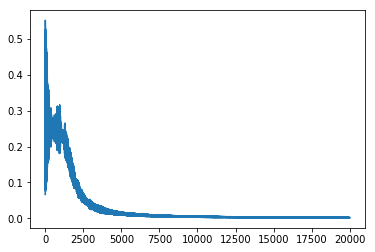

In [12]:
plt.plot(result[1])
plt.show()

### Batch training

In [25]:
epoch_error = []
epochs = 10000
params = init_net(2,2,1, 1)
batch_error = []

for epoch in range(0,epochs):
    params = batch_train_neuralnet(i,o,0.1,params,2)
    j = randrange(0,9)
    p = forwardPass(i[j], o[j], params)
    s = np.array(p["final_error"])
    e = s.dot(s)
    batch_error.append(e)
    del p,s,e

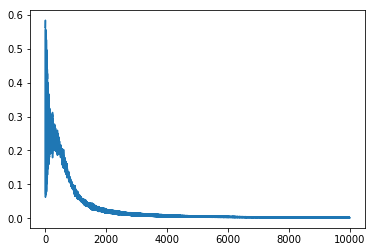

In [26]:
plt.plot(batch_error)
plt.show()